In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout
from keras.optimizers import Adam, Nadam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
from statistics import mean

sns.set(style='darkgrid', palette='muted', font_scale=1.5, rc={'figure.figsize':(20,10)})

RANDOM_SEED = 32
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [26]:
import glob
import pickle
def open_best_results():
    files = glob.glob('./fitted_models/*fitted_models.pkl')
    
    all_models = []
    for file in files:
        with open(file, 'rb') as f:
            [all_models.append(df) for df in pickle.load(f)]
    return all_models

In [27]:
def open_original(name):
    with open(f'../original/{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [28]:
original_ica = open_original('complete_ica')
original_ica.tail(15)

,artiklar,weekday,day_of_month,holiday,before_holiday,payday,pension
2021-03-27,884.0,5,27,0,0,0,0
2021-03-28,0.0,6,28,0,0,0,0
2021-03-29,1446.0,0,29,0,1,0,0
2021-03-30,3495.0,1,30,0,2,0,0
2021-03-31,4918.0,2,31,0,3,0,0
2021-04-01,8878.0,3,1,1,0,0,0
2021-04-02,0.0,4,2,0,0,0,0
2021-04-03,865.0,5,3,1,0,0,0
2021-04-04,0.0,6,4,1,0,0,0
2021-04-05,0.0,0,5,0,0,0,0


In [29]:
best_dfs = open_best_results()
print(len(best_dfs))

6


In [30]:
def get_top(df_list, num):
    return sorted(df_list, key=lambda df: df['score']['r2'], reverse=True)[:num]

In [31]:
top_dfs = get_top(best_dfs, 9)
for d in top_dfs:
    print(d['score'])

{'RMSE': 134.28019824463993, 'MAE': 106.67124285016745, 'r2': 0.9912473170873286}
{'RMSE': 159.42586693641218, 'MAE': 135.13183157784601, 'r2': 0.9876622824825375}
{'RMSE': 166.29858673596567, 'MAE': 131.01176670619526, 'r2': 0.9865756160536701}
{'RMSE': 173.16721677230217, 'MAE': 145.3027474539621, 'r2': 0.9854437803119127}
{'RMSE': 214.21345666361887, 'MAE': 192.7349112374437, 'r2': 0.9777253572982675}
{'RMSE': 375.7705648142055, 'MAE': 328.9483424595424, 'r2': 0.931457054570779}


### Make predictions DF based on prev x_train & first x_test

In [54]:
def predict_on_predictions(df_list, original_df, start_pred='2021-03-22', predict_days=7):
    next_week_predictions = []
    
    start_pred = pd.to_datetime(start_pred)
    
    for i, df in enumerate(df_list, 1):
#         out_of_index = True if start_pred + pd.to_timedelta(predict_days, unit='d') > original_df.index[-1] else False

        next_week_x = original_df.loc[start_pred:start_pred + pd.to_timedelta(predict_days - 1, unit='d'), df['features']]
        x_test = df['scaler_x'].transform(original_df.loc[start_pred - pd.to_timedelta(df['time_steps'], unit='d'): start_pred - pd.to_timedelta(1, unit='d'), df['features']])
        x_test = pd.DataFrame(x_test, columns=df['features'])

        y_test = original_df.loc[start_pred: start_pred + pd.to_timedelta(predict_days - 1, unit='d'), 'artiklar']
        x_test['pred_artiklar'] = x_test['artiklar']

        scaled_next_week = pd.concat((x_test, pd.DataFrame(df['scaler_x'].transform(next_week_x), columns=x_test.columns[:-1])))
        
        cols = list(scaled_next_week.columns)
        a, b = cols.index('artiklar'), cols.index('pred_artiklar')
        cols[b], cols[a] = cols[a], cols[b]
        scaled_next_week = scaled_next_week[cols]
        
        model = keras.models.load_model(df['model'])

        print(f'> Making predictions for model: {i}/{len(df_list)} <'.center(50, '-'))
        
        for i in range(predict_days):
            y_pred = model.predict(scaled_next_week.iloc[i:i + df['time_steps'], :-1].to_numpy().reshape(-1, df['X_train'].shape[1], df['X_train'].shape[2]))
            scaled_next_week.iloc[(i + df['time_steps']), 0] = y_pred[0]
            
        for i in ['artiklar', 'pred_artiklar']:
            scaled_next_week[i] = df['scaler_y'].inverse_transform(scaled_next_week[i].to_numpy().reshape(-1, 1))

        next_week_pred = scaled_next_week.reset_index(drop=True)
    
        df['next_week'] = next_week_pred
        y_pred = df['next_week'].iloc[-predict_days:, 0]
        y_true = y_test.to_numpy().reshape(-1, 1)
                
        # TODO unscale all X Values 
        df['new_score'] = {'RMSE': np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)),
                           'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
                           'r2': r2_score(y_true=y_true, y_pred=y_pred)}
        df['predicted_days'] = predict_days
        next_week_predictions.append(df)
        
    return next_week_predictions

In [59]:
next_week_predictions = predict_on_predictions(top_dfs, original_ica, start_pred='2021-03-22', predict_days=14)

------> Making predictions for model: 1/6 <-------
------> Making predictions for model: 2/6 <-------
------> Making predictions for model: 3/6 <-------
------> Making predictions for model: 4/6 <-------
------> Making predictions for model: 5/6 <-------
------> Making predictions for model: 6/6 <-------


In [60]:
for d in next_week_predictions:
    print(d['score'])
    print(d['new_score'])

{'RMSE': 134.28019824463993, 'MAE': 106.67124285016745, 'r2': 0.9912473170873286}
{'RMSE': 831.3418334698357, 'MAE': 520.7408666683529, 'r2': 0.8803317272623044}
{'RMSE': 159.42586693641218, 'MAE': 135.13183157784601, 'r2': 0.9876622824825375}
{'RMSE': 885.2733451561747, 'MAE': 596.814820923128, 'r2': 0.8643016618459893}
{'RMSE': 166.29858673596567, 'MAE': 131.01176670619526, 'r2': 0.9865756160536701}
{'RMSE': 910.0636781315593, 'MAE': 575.9913700539722, 'r2': 0.856595323020428}
{'RMSE': 173.16721677230217, 'MAE': 145.3027474539621, 'r2': 0.9854437803119127}
{'RMSE': 879.2869895634236, 'MAE': 602.832337957712, 'r2': 0.8661306831997091}
{'RMSE': 214.21345666361887, 'MAE': 192.7349112374437, 'r2': 0.9777253572982675}
{'RMSE': 903.1256745297279, 'MAE': 590.9424610590935, 'r2': 0.8587735214160712}
{'RMSE': 375.7705648142055, 'MAE': 328.9483424595424, 'r2': 0.931457054570779}
{'RMSE': 843.2353754762768, 'MAE': 563.308851410903, 'r2': 0.8768831803392645}


In [61]:
def plot_all_predictions(df_list):
    
    rows = len(df_list) // 3 if len(df_list) % 3 == 0 else (len(df_list) // 3) + 1
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, rows * 5))
    fig.suptitle('Next week predictions', size=30)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.set_title(f'R2: {df_list[i]["new_score"]["r2"]:0.4f} RMSE: {df_list[i]["new_score"]["RMSE"]:0.2f} MAE: {df_list[i]["new_score"]["MAE"]:0.2f}', size=15)
        ax.plot(df_list[i]['next_week']['artiklar'], label='True', marker='.')
        ax.plot(df_list[i]['next_week'].iloc[-df_list[i]['predicted_days']: ,0], label='Predicted', marker='.')
        ax.legend(loc="lower left", prop={'size': 12})
        ax.tick_params(labelsize=12)
        if i == len(df_list) - 1:
            break

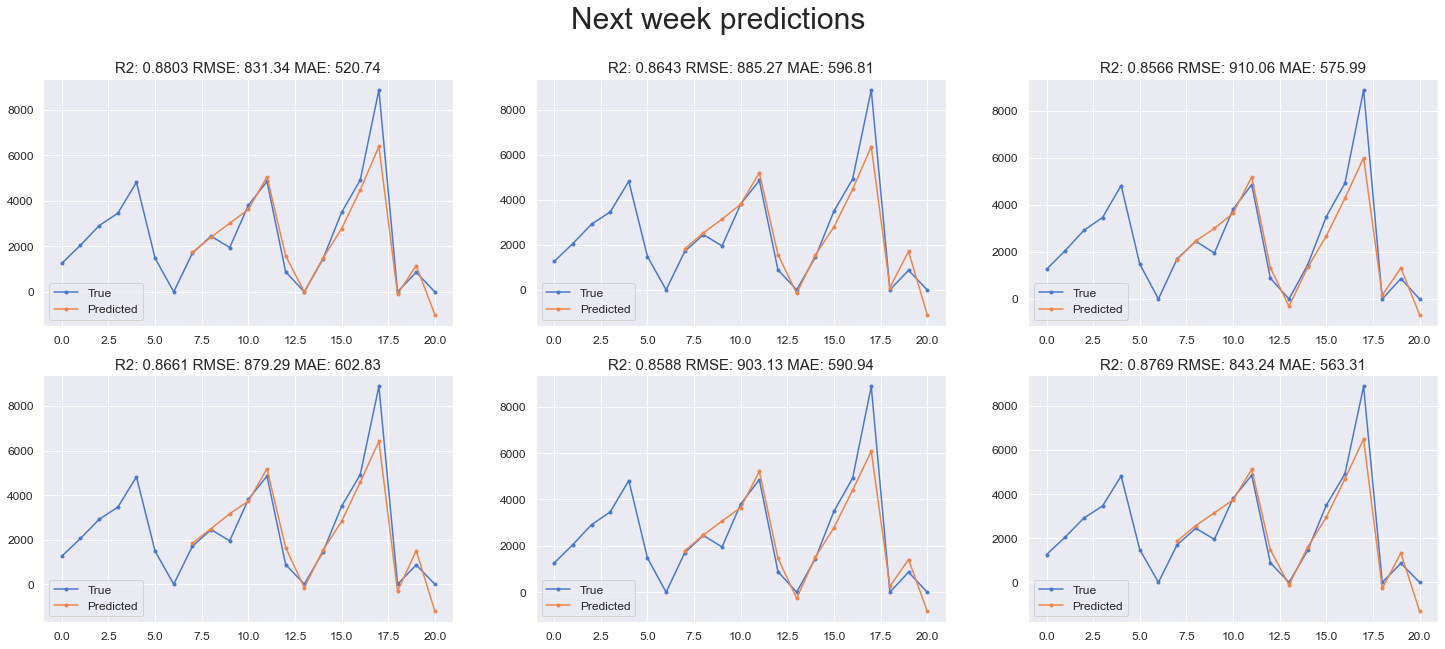

In [62]:
plot_all_predictions(next_week_predictions)